In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from transformers import pipeline

2023-04-23 00:36:53.667949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/cs109b/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problem Statement

Our main research question is: **Can we use the text of user reviews to predict the star ratings for reviews of businesses in Philadelphia?**

# Exploratory Data Analysis

## Loading Data
The initial dataset was quite large (even when we limited our focus to only Philadelphia). Thus, we had to split the `.csv` files up, which is why we have this slightly clunky import code. 

In [3]:
# load in business data
business = pd.read_json('data/yelp_academic_dataset_business.json', lines=True)
# keep only those businesses in the city with the most observations (Philadelphia)
# and only businesses which are restaurants
max_city = business['city'].value_counts().idxmax()
business = business.loc[(business['city'] == max_city) & (business['categories']).str.contains('Restaurants')]

In [4]:
# load in review data from separate csv's located in data folder
review = []
for i in range(1, 8):
    review.append(pd.read_csv(f'data/review{i}.csv'))
review = pd.concat(review)

### Inspecting `business`

We don't really have to worry about missing values for our `business` dataset. The only featurse with any missing values are `hours` and `attributes` (itself a dictionary of binary categories which describe the business, such as "nice ambiance" or "good views") which we are not planning on incorporating into our model. 

In [5]:
business.isnull().sum()/len(business.index)

business_id     0.000000
name            0.000000
address         0.000000
city            0.000000
state           0.000000
postal_code     0.000000
latitude        0.000000
longitude       0.000000
stars           0.000000
review_count    0.000000
is_open         0.000000
attributes      0.009057
categories      0.000000
hours           0.170540
dtype: float64

In [6]:
business.describe()

,latitude,longitude,stars,review_count,is_open
count,5852.000000,5852.000000,5852.000000,5852.000000,5852.000000
mean,39.974770,-75.154157,3.555964,113.761449,0.602358
std,0.048136,0.051395,0.803122,241.378560,0.489452
min,39.865466,-75.363647,1.000000,5.000000,0.000000
25%,39.947944,-75.176438,3.000000,14.000000,0.000000
50%,39.954445,-75.160408,3.500000,38.500000,1.000000
75%,39.999755,-75.144601,4.000000,114.000000,1.000000
max,40.141488,-74.940729,5.000000,5721.000000,1.000000


It seems that four- and five-star reviews are more common than lower ratings, which later motivates our decision to consider four and five star reviews to be positive, while considering one to three star reviews to be negative. 

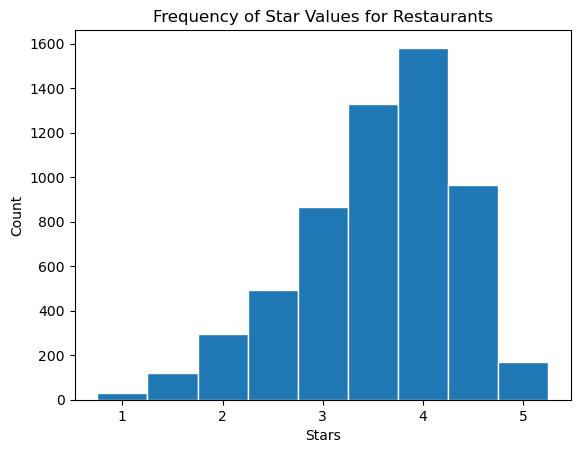

In [7]:
plt.hist(business['stars'], bins=np.arange(0.75, 5.75, 0.5), edgecolor="white")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.title("Frequency of Star Values for Restaurants")
plt.show()

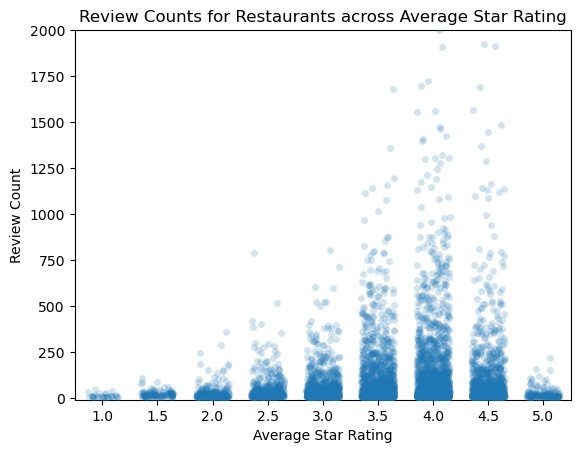

In [8]:
sns.stripplot(data=business, x='stars', y='review_count', alpha = 0.2, jitter=0.3)
plt.ylim(-10, 2000)
plt.xlabel("Average Star Rating")
plt.ylabel("Review Count")
plt.title("Review Counts for Restaurants across Average Star Rating");

### Inspecting `reviews`

In [9]:
review.isnull().sum()/len(review.index)

review_id      0.0
user_id        0.0
business_id    0.0
stars          0.0
useful         0.0
funny          0.0
cool           0.0
text           0.0
date           0.0
dtype: float64

In [10]:
review.describe()

,stars,useful,funny,cool
count,687289.000000,687289.000000,687289.000000,687289.000000
mean,3.811699,1.101761,0.370848,0.550538
std,1.306959,2.531508,1.430542,1.850401
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,1.000000
max,5.000000,224.000000,227.000000,163.000000


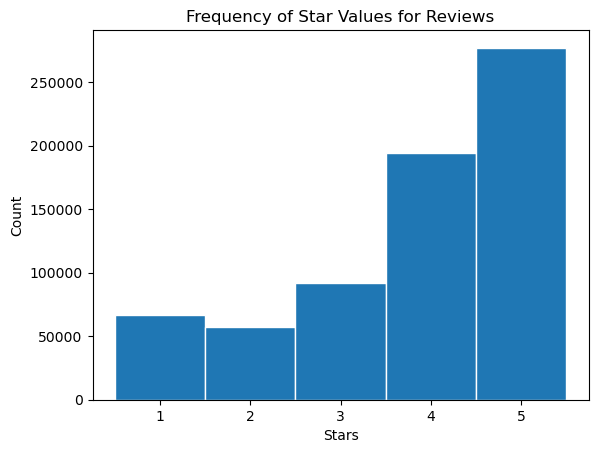

In [11]:
plt.hist(review['stars'], bins=np.arange(0.5, 6.5, 1), edgecolor="white")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.title("Frequency of Star Values for Reviews")
plt.show()

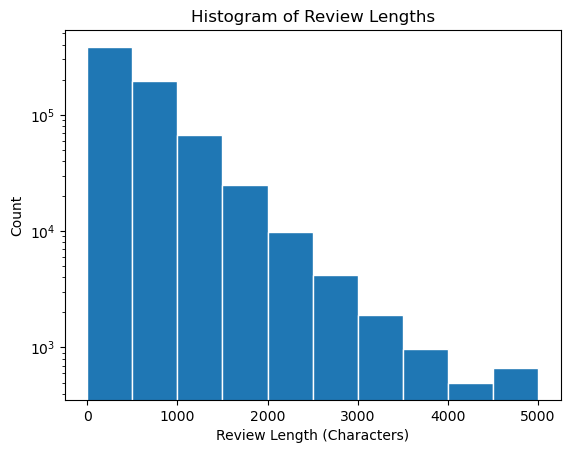

In [12]:
plt.hist(review['text'].str.len(), edgecolor="white")
plt.xlabel('Review Length (Characters)')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Histogram of Review Lengths')
plt.show()

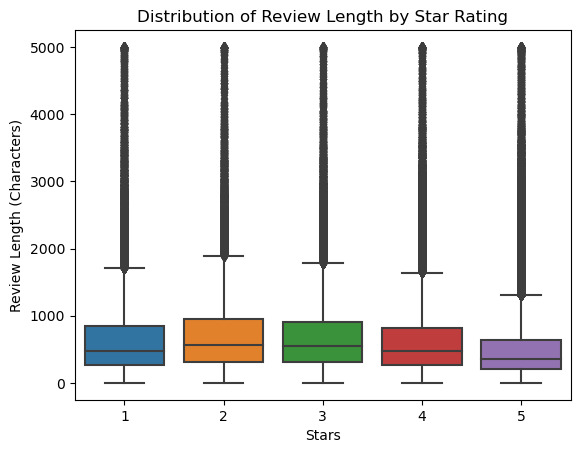

In [13]:
sns.boxplot(x=review['stars'], y=review['text'].str.len())
plt.xlabel("Stars")
plt.ylabel("Review Length (Characters)")
plt.title("Distribution of Review Length by Star Rating");

## Text Processing

In order to prepare `reviews`, we simply use `text` as our input variable and `stars` as our output variable. We then save the arrays for future use. However, in order to feed `text` into a neural network, we first had to tokenize it -- this process took a long time, so the code is commented out (so that it is not accidentally run). We utilized `TreebankWordTokenizer()` in order to pre-process the text. Additionally, because we chose to pad the sequences, we started counting our word to index dictionary at 1. 

In [ ]:
## borrow TreebankWordTokenizer() 
## UNCOMMENT TO RUN BUT ALSO DO NOT RUN
# def clean(string):
#     return TreebankWordTokenizer().tokenize(string.lower())

# review['text'] = review['text'].apply(clean)
# words = review['text'].apply(set)
# words = set().union(*words)
# len(words)

In [ ]:
# word2idx = {w: i + 1 for i, w in enumerate(words)}

# X = review['text'].apply(lambda r: [word2idx[w] for w in r])
# X

In [ ]:
# max_words = max([len(i) for i in X])
# X = pad_sequences(X, max_words)
# X.shape

In [ ]:
# y = review['stars'].to_numpy()
# np.savez_compressed('data/reviews.npz', X=X, y=y)

## Baseline Models

### LSTM
For our baseline model, we decided to use an LSTM in order to predict the number of stars which a user gives a restaurant based on their review. Note that at this point we simply load the data from a saved numpy file (see above) for greater efficiency in running the notebook/testing and training the model. 

This seemed like a reasonable baseline model based on our work in class, given that some sort of RNN seemed much better suited to our task than naively using a FFNN. 

In [32]:
# for quick loading
reviews = np.load('data/reviews.npz')
X_train, y_train = reviews['X'], reviews['y']
X_train.shape, y_train.shape

((687289, 1093), (687289,))

In [33]:
# tokenize
with open('data/word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)
word2idx
idx2word = {v: k for k,v in word2idx.items()}

In [34]:
inputs = Input(shape=(X_train.shape[1],))
n = Embedding(len(word2idx) + 1, 32, mask_zero=True)(inputs)
n = LSTM(32)(n)
outputs = Dense(5, activation='softmax')(n)
model = Model(inputs=inputs, outputs=outputs)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

2023-04-23 00:57:55.636556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1093)]            0         
                                                                 
 embedding (Embedding)       (None, 1093, 32)          11687808  
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 11,696,293
Trainable params: 11,696,293
Non-trainable params: 0
_________________________________________________________________


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.5)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((68728, 1093), (68729, 1093), (549832, 1093), (68728,), (68729,), (549832,))

In [ ]:
model.fit(X_train, y_train - 1, validation_data=(X_val, y_val - 1), batch_size=1024, epochs=10)

Epoch 1/10
68/68 [==============================] - 252s 4s/step - loss: 1.4242 - accuracy: 0.3559 - val_loss: 1.1981 - val_accuracy: 0.4435
Epoch 2/10
57/68 [========================>.....] - ETA: 31s - loss: 1.0991 - accuracy: 0.4958

In [ ]:
plt.plot(range(1, 11), model.history.history['loss'], label='train')
plt.plot(range(1, 11), model.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.legend()
plt.grid()
plt.show()

### Validation
In order to test this model on new input, we created a simple function which tokenized and padded sample reviews. It seems that our model is fairly close to predicting stars in the same way we would (when we use `argmax` to find the class with the highest probability). In particular, the model is good at predicting the extreme negativity expressed in the final review we tested. 

In [ ]:
def as_input(string):
    return pad_sequences(np.array([[word2idx[w] for w in TreebankWordTokenizer().tokenize(string.lower())]]), max_words)

In [ ]:
model.predict(as_input('This food is so bad'))

In [ ]:
model.predict(as_input('This food is so good'))

In [ ]:
model.predict(as_input('One of the worst places Ive been, unfortunately! Rude staff, horrible service and tasteless food and coffee. Would never come back or recommend this place.'))

In [ ]:
from sklearn.metrics import confusion_matrix 
y_pred = np.argmax(model.predict(X_test, batch_size = 1024), axis = -1).flatten() 

# Creating a confusion matrix,which compares the y_test and y_pred cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4, 5], columns = [1, 2, 3, 4, 5]) 
#Plotting the confusion matrix plt.figure(figsize=(5,4)) 
sns.heatmap(cm_df, annot=True) 
plt.title('Confusion Matrix') 
plt.ylabel('Actal Values') plt.xlabel('Predicted Values') plt.show()